--- 1. Chargement du Modèle et des Données ELO ---
Modèle de Régression Logistique chargé avec succès.
Scores ELO actuels chargés pour 182 équipes.
Nombre de matchs à prédire : 5

--- 5. Prédiction des Probabilités de Matchs ---
Classes prédites par le modèle: [-1.0, 0.0, 1.0]

--- RÉSULTATS DES PRÉDICTIONS (CAN 2025) ---
   Domicile    Exterieur  Neutre  Prob. Défaite Domicile (-1)  Prob. Nul (0)  \
0   Morocco       Zambia       0                     0.054660       0.165266   
1   Nigeria  Ivory Coast       1                     0.331049       0.329713   
2   Senegal        Egypt       1                     0.262588       0.319030   
3   Algeria     Cameroon       1                     0.236829       0.298095   
4  DR Congo         Mali       0                     0.161147       0.284704   

   Prob. Victoire Domicile (1)  
0                     0.780075  
1                     0.339238  
2                     0.418382  
3                     0.465076  
4                     0.554149

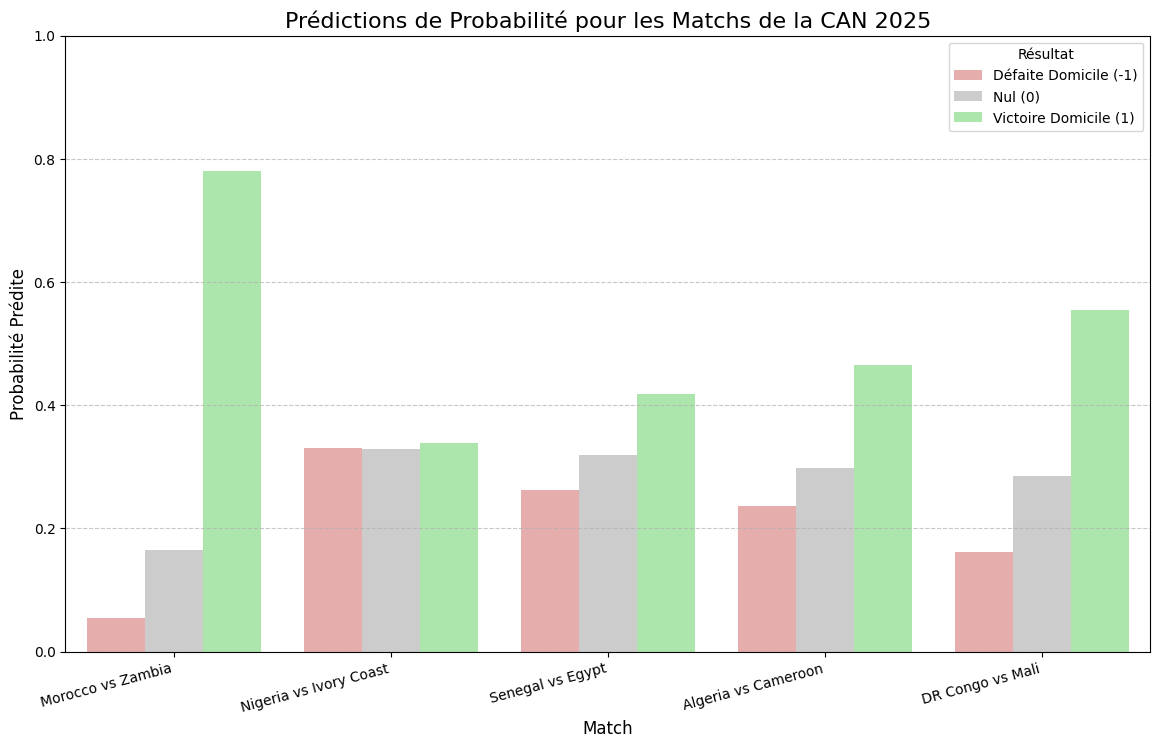


--- Synthèse des Gagnants Prédits ---
   Domicile    Exterieur     Gagnant Prédit
0   Morocco       Zambia  Victoire Domicile
1   Nigeria  Ivory Coast  Victoire Domicile
2   Senegal        Egypt  Victoire Domicile
3   Algeria     Cameroon  Victoire Domicile
4  DR Congo         Mali  Victoire Domicile


In [4]:
# ==============================================================================
# 03_Prediction.ipynb - Prédiction des Matchs de la CAN 2025 (VERSION FINALE CORRIGÉE)
# ==============================================================================

import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
import sys
import matplotlib.pyplot as plt
import seaborn as sns
# (Les autres imports doivent être déjà là : pandas, numpy, joblib, etc.)

# --- Définition des Constantes (CORRIGÉ : Résout NameError) ---
HOME_FIELD_ADVANTAGE_FEATURE = 100 
# ---------------------------------------------

# --- 1. Chargement du Modèle et des Données d'Entrée ---

print("--- 1. Chargement du Modèle et des Données ELO ---")

# Charger le modèle sauvegardé
try:
    model = joblib.load('../models/logistic_regression_model.joblib')
    print("Modèle de Régression Logistique chargé avec succès.")
except FileNotFoundError:
    print("Erreur: Le fichier modèle n'a pas été trouvé. Assurez-vous d'exécuter 02_Modeling.ipynb.")
    sys.exit() 

# Charger le DataFrame enrichi pour obtenir les scores ELO finaux
df_elo = pd.read_csv('../data/processed/can_processed_data_with_elo.csv')
df_elo['date'] = pd.to_datetime(df_elo['date']) 


# --- 2. Calcul des Scores ELO Actuels (basés sur le dernier match) ---

# Fonction pour obtenir le dernier score ELO d'une équipe
def get_final_elo_scores(df):
    
    # CORRIGÉ : Utiliser 'home_elo' et 'away_elo' qui existent dans le CSV (résout KeyError)
    last_home_match = df.groupby('home_team').last().reset_index()[['home_team', 'home_elo']]
    last_away_match = df.groupby('away_team').last().reset_index()[['away_team', 'away_elo']]
    
    # Renommer les colonnes pour standardiser
    last_home_match.columns = ['team', 'elo']
    last_away_match.columns = ['team', 'elo']
    
    # Combiner les deux et ne garder que le dernier ELO connu
    final_elos = pd.concat([last_home_match, last_away_match])
    
    # GroupBy max s'assure que nous prenons le score ELO le plus récent/final
    final_elos = final_elos.groupby('team')['elo'].max().to_dict()
    
    return final_elos

current_elo_ratings = get_final_elo_scores(df_elo)

print(f"Scores ELO actuels chargés pour {len(current_elo_ratings)} équipes.")

# --- 3. Définition des Matchs à Prédire ---

PREDICTION_DATE = pd.to_datetime('2025-01-01') 

matchs_can = [
    # Matchs simulés pour l'exemple
    {'date': PREDICTION_DATE, 'home_team': 'Morocco', 'away_team': 'Zambia', 'tournament': 'CAN 2025', 'neutral': 0},
    {'date': PREDICTION_DATE, 'home_team': 'Nigeria', 'away_team': 'Ivory Coast', 'tournament': 'CAN 2025', 'neutral': 1},
    {'date': PREDICTION_DATE, 'home_team': 'Senegal', 'away_team': 'Egypt', 'tournament': 'CAN 2025', 'neutral': 1},
    {'date': PREDICTION_DATE, 'home_team': 'Algeria', 'away_team': 'Cameroon', 'tournament': 'CAN 2025', 'neutral': 1},
    {'date': PREDICTION_DATE, 'home_team': 'DR Congo', 'away_team': 'Mali', 'tournament': 'CAN 2025', 'neutral': 0},
]

df_predict = pd.DataFrame(matchs_can)
print(f"Nombre de matchs à prédire : {df_predict.shape[0]}")


# --- 4. Préparation des Features pour la Prédiction ---

# Récupérer les points FIFA moyens (Approximation)
mean_points = df_elo[['home_points', 'home_team']].rename(columns={'home_points': 'points', 'home_team': 'team'})
mean_points = mean_points.groupby('team')['points'].mean().to_dict()

# Ajouter les features ELO et Points FIFA au DataFrame de prédiction
df_predict['home_elo'] = df_predict['home_team'].map(current_elo_ratings).fillna(1500)
df_predict['away_elo'] = df_predict['away_team'].map(current_elo_ratings).fillna(1500)

df_predict['home_points'] = df_predict['home_team'].map(mean_points).fillna(1500)
df_predict['away_points'] = df_predict['away_team'].map(mean_points).fillna(1500)

# Créer les features X_predict
df_predict['elo_diff'] = df_predict['home_elo'] - df_predict['away_elo']
df_predict['points_diff'] = df_predict['home_points'] - df_predict['away_points']

# L'avantage du terrain est appliqué si le match n'est pas neutre (utilise la constante corrigée)
df_predict['home_adv'] = np.where(
    df_predict['neutral'] == 0, 
    HOME_FIELD_ADVANTAGE_FEATURE, 
    0
)

X_predict = df_predict[['elo_diff', 'points_diff', 'home_adv']]


# --- 5. Prédiction des Probabilités ---

print("\n--- 5. Prédiction des Probabilités de Matchs ---")

# Prédire les probabilités [P(Away Win), P(Draw), P(Home Win)]
probabilities = model.predict_proba(X_predict)
proba_df = pd.DataFrame(probabilities, columns=['P(Away Win)', 'P(Draw)', 'P(Home Win)'])

# Déterminer les classes que le modèle a prédites
class_labels = model.classes_
print(f"Classes prédites par le modèle: {class_labels.tolist()}")


# --- 6. Affichage des Résultats ---

df_results = df_predict[['home_team', 'away_team', 'neutral']].reset_index(drop=True)
df_final_results = pd.concat([df_results, proba_df], axis=1)

# Renommer les colonnes de probabilité selon les labels du modèle
df_final_results.columns = [
    'Domicile', 
    'Exterieur', 
    'Neutre', 
    'Prob. Défaite Domicile (-1)', 
    'Prob. Nul (0)', 
    'Prob. Victoire Domicile (1)'
]

print("\n--- RÉSULTATS DES PRÉDICTIONS (CAN 2025) ---")
print(df_final_results)

print("\n✅ PRÉDICTION TERMINÉE.")

# ==============================================================================
# 7. Visualisation des Résultats
# ==============================================================================

print("\n--- 7. Visualisation des Résultats ---")

# Créer un DataFrame pour le graphique
df_plot = df_final_results.copy()

# 1. Identifier le gagnant le plus probable
# Les colonnes de probabilités sont : [Défaite Domicile, Nul, Victoire Domicile]
proba_cols = ['Prob. Défaite Domicile (-1)', 'Prob. Nul (0)', 'Prob. Victoire Domicile (1)']

# Créer une nouvelle colonne pour le Résultat le plus probable
df_plot['Gagnant Prédit'] = df_plot[proba_cols].idxmax(axis=1).map({
    'Prob. Défaite Domicile (-1)': 'Victoire Exterieur',
    'Prob. Nul (0)': 'Match Nul',
    'Prob. Victoire Domicile (1)': 'Victoire Domicile'
})

# 2. Préparer les données pour le graphique (format long)
df_viz = df_plot.melt(
    id_vars=['Domicile', 'Exterieur', 'Gagnant Prédit'],
    value_vars=proba_cols,
    var_name='Résultat',
    value_name='Probabilité'
)

# Créer une étiquette de match pour l'axe X
df_viz['Match'] = df_viz['Domicile'] + ' vs ' + df_viz['Exterieur']
df_viz['Résultat'] = df_viz['Résultat'].str.replace('Prob. ', '')

# 3. Création du graphique à barres
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_viz, 
    x='Match', 
    y='Probabilité', 
    hue='Résultat', 
    palette={'Défaite Domicile (-1)': '#f0a3a3', 'Nul (0)': '#cccccc', 'Victoire Domicile (1)': '#a3f0a3'}
)

plt.title('Prédictions de Probabilité pour les Matchs de la CAN 2025', fontsize=16)
plt.xlabel('Match', fontsize=12)
plt.ylabel('Probabilité Prédite', fontsize=12)
plt.ylim(0, 1)
plt.legend(title='Résultat', loc='upper right')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Afficher le résumé pour confirmer le gagnant
print("\n--- Synthèse des Gagnants Prédits ---")
print(df_plot[['Domicile', 'Exterieur', 'Gagnant Prédit']])